# Yelp grossometer

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

main_directory = r'C:\Users\ASUS\Desktop\ML-data science\DataIncubator\yelp-cleaners' + '\\'
processed_data_directory = main_directory + r'data\processed data' + '\\'

In [2]:
business_df_latest = pd.read_csv(processed_data_directory + 'business_df_latest_inspection.csv')
business_df = pd.read_csv(processed_data_directory + 'business_df.csv')
review_df = pd.read_csv(processed_data_directory + 'review_df.csv')

In [142]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, LogisticRegression

In [234]:
import spacy
# nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS = STOP_WORDS.union({'ll', 've'})
from sklearn.naive_bayes import MultinomialNB

# process dataset

## score based on review date

Let's strip the dataframes of all unnecessary features, leaving only the business_id, inspection score & date, review score & date. Then we look for the inspection nearest to each individual review in time, and use that inspection score for the 'cleanliness' of the business at the time of the review.

We set a tolerance of 2 years to exclude all reviews that are 2 years away from an inspection. This limits us to reviews posted from 2017 to 2021, cutting down the dataset by 50%.

In [179]:
bare_bones_bdf = business_df[['business_id','Inspection Date','Score','stars']].rename({'Inspection Date':'date'},axis=1).copy()
bare_bones_bdf['date'] = pd.to_datetime(bare_bones_bdf['date'])

In [180]:
bare_bones_rdf = review_df[['business_id','review_id','text','date','review_stars']].copy()
bare_bones_rdf['date'] = pd.to_datetime(bare_bones_rdf['date'])
bare_bones_rdf

,business_id,review_id,text,date,review_stars
0,mOnesB4IF9j6-ZmHoOHOig,GDgXjXSZCA1iNQWD7OHXfg,I think their rice dishes are way better than ...,2017-05-26 03:05:46,4
1,-_GnwXmzC3DXsHR9nyaC2g,GgWFjRHhelaiUgR2-H6N4g,3.5 stars! I got the avocado margarita and it ...,2012-11-06 07:09:57,3
2,bZiIIUcpgxh8mpKMDhdqbA,z-6ElnK3yXpn2oNKR7NYtw,My husband and I shared the parmesan truffly f...,2017-10-11 00:25:47,3
3,gvpoFnaCq2J7TBXV7yFIkQ,nqUJoSkDr_1mqnLtOrWFSA,"Perfect spices, nice atmosphere & music, great...",2017-07-28 19:17:54,5
4,LUCmOKTK5Uh7eU84yJq3mQ,h6o5mduBqDUkKsa4KRIDzw,Snap is my go-to lunch spot nearly every day! ...,2015-06-08 18:07:06,5
...,...,...,...,...,...
570609,dgywJM4JpniwOEDNfrfewg,I_8BJ6vZo7mVHi4TzuEK2A,I rec'd my meal as part of a complimentary Yel...,2020-08-09 19:53:40,2
570610,Qmq4gr5Mmo2oIVejag48PA,oabuTmGpHquA4sc4C0DatQ,This place serves amazingly tasty gluten free ...,2020-09-13 00:53:03,4
570611,zM98ZSIJyuBQabyYornLpw,hKxvxtCjEJAwD_7AcnA_iQ,Bartender was friendly and attentive. We came ...,2021-01-10 04:10:45,3
570612,Wn8j-1-ity6hdjP4bC_wkw,UWHPbsQzfrmjtDCbq2AeDg,Terrible pho. Literally zero flavor. And the c...,2021-01-17 22:09:10,2


In [181]:
business_ids = bare_bones_bdf.business_id.unique()

In [182]:
%%time
# merge score and review dataframes based on closeness in time
# needs to be done in a loop over business_id because merge_asof only works with one column
biz_df_list = []
tolerance = pd.Timedelta(days = 365*2) # two year tolerance
for bid in business_ids:
    indiv_biz_scores = bare_bones_bdf[bare_bones_bdf['business_id']==bid]
    indiv_biz_reviews = bare_bones_rdf[bare_bones_rdf['business_id']==bid].sort_values('date')
    out = pd.merge_asof(indiv_biz_reviews,indiv_biz_scores,on='date',direction='nearest',tolerance=tolerance).dropna()
    out = out.drop('business_id_y',axis=1).rename(columns={'business_id_x':'business_id'})
    biz_df_list.append(out)

Wall time: 2min 25s


In [183]:
df = pd.concat(biz_df_list, ignore_index=True, join='outer', axis=0)
df.to_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv', index=False)

In [65]:
sorted(df['date'])[0]

Timestamp('2017-04-29 16:35:26')

In [66]:
sorted(df['date'])[-1]

Timestamp('2021-01-28 15:30:21')

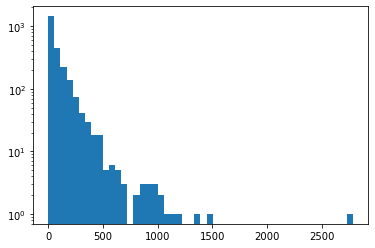

In [79]:
# review distribution
plt.hist(df.business_id.value_counts(), bins=50)
plt.yscale('log')

## some more processing

In [ ]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [ ]:
# discard businesses with < 10 reviews
n = 10
less_than_n_reviews = df.business_id.value_counts()[df.business_id.value_counts() < n].index
df = df[~df['business_id'].isin(less_than_n_reviews)]

# bag of words model

## dataset subset

In [202]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [185]:
# let's just look at businesses with 50-100 reviews
num_reviews = df.business_id.value_counts()
valid_businesses = num_reviews[(num_reviews <= 100) & (num_reviews >= 50)].index
df = df[df['business_id'].isin(valid_businesses)].reset_index(drop=True)

In [203]:
df

,business_id,review_id,text,date,review_stars,Score,stars
0,NRPemqVb4qpWFF0Avq_6OQ,OWkPkotszUbmqxDFHkN-xg,Got takeout from there tonight and loved every...,2017-05-10 00:58:09,5,76.0,4.5
1,NRPemqVb4qpWFF0Avq_6OQ,p8G2JIEzGIgbH347qJLM8g,Indonesian Italian Japanese restaurant. Yes. Y...,2017-05-13 02:21:41,5,76.0,4.5
2,NRPemqVb4qpWFF0Avq_6OQ,q5GjvJGxWTg44MpwLVRpYQ,I'd been want nah to try this place out since ...,2017-05-15 22:43:24,5,76.0,4.5
3,NRPemqVb4qpWFF0Avq_6OQ,XsIuCQsmgNwZz0UCLb2XgA,Really a great find. This place is a diamond. ...,2017-05-17 00:44:54,5,76.0,4.5
4,NRPemqVb4qpWFF0Avq_6OQ,BzD7FAmpkc0S41QB84fQhw,Wow! So glad to see some great places coming ...,2017-05-21 01:30:47,5,76.0,4.5
...,...,...,...,...,...,...,...
216612,EaBDXdIQ_TeeUhn1Twnjvg,o7KKw9gZ1zADWR3OvwJOjQ,I've heard only good things about this noodle ...,2019-10-28 02:35:05,5,73.0,3.5
216613,EaBDXdIQ_TeeUhn1Twnjvg,vKLOotHW3NGAWGd_AKmrxw,I've had a very hot or miss experience with sh...,2019-11-20 00:57:20,4,73.0,3.5
216614,EaBDXdIQ_TeeUhn1Twnjvg,RqU0sEZcHc25RWap4v9_5A,The best Chinese food we have found in the are...,2019-11-23 21:38:24,5,73.0,3.5
216615,EaBDXdIQ_TeeUhn1Twnjvg,zvZR61Ioy-5dhw_3Q3kPFw,This is a small and simple restaurant but such...,2020-01-17 01:25:08,5,73.0,3.5


In [204]:
reviews = np.array(df['text'])
scores = np.array(df['Score'])

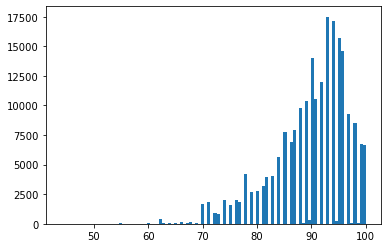

In [205]:
# scores look skewed, mayeb do logistic regression?
plt.hist(scores,bins=100)
plt.show()

## bow model

In [231]:
# test with small data
X, y = shuffle(reviews, scores, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [232]:
len(X_train)

173293

In [242]:
%%time
# bow_vectorizer = CountVectorizer(min_df=10,max_df=0.75)
bow_vectorizer = TfidfVectorizer(min_df=5,
                                 max_df=0.75,
                                 max_features=10000,
                                 stop_words=STOP_WORDS)
est = Pipeline([
    ('vect', bow_vectorizer),
    ('regressor', Ridge())
])
est.fit(X_train, y_train)
print(f'R^2 score: {est.score(X_test, y_test)}')

R^2 score: 0.1785885576959767
Wall time: 21.4 s


In [243]:
parameters = {
    'vect__max_features': [1000,5000,10000]
#     'vect__max_df': [0.25,0.5,0.75]
    # 'regressor__alpha': [0.001,1.0]
}
gs = GridSearchCV(est, parameters)

In [244]:
%%time
gs.fit(X,y)

Wall time: 5min 23s


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.75,
                                                        max_features=5000,
                                                        min_df=10,
                                                        stop_words={"'d", "'ll",
                                                                    "'m", "'re",
                                                                    "'s", "'ve",
                                                                    'a',
                                                                    'about',
                                                                    'above',
                                                                    'across',
                                                                    'after',
                                                                    'afterwards',
                                  

In [245]:
gs.best_params_

{'vect__max_features': 10000}

In [246]:
parameters = {
    'vect__min_df': [5,10,20]
#     'vect__max_df': [0.25,0.5,0.75]
    # 'regressor__alpha': [0.001,1.0]
}
gs = GridSearchCV(est, parameters)

In [247]:
%%time
gs.fit(X,y)

Wall time: 5min 46s


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.75,
                                                        max_features=5000,
                                                        min_df=10,
                                                        stop_words={"'d", "'ll",
                                                                    "'m", "'re",
                                                                    "'s", "'ve",
                                                                    'a',
                                                                    'about',
                                                                    'above',
                                                                    'across',
                                                                    'after',
                                                                    'afterwards',
                                  

In [248]:
gs.best_params_

{'vect__min_df': 5}

In [252]:
parameters = {
    # 'vect__min_df': [5,10,100]
    'vect__max_df': [0.5,0.75,0.9]
    # 'regressor__alpha': [0.001,1.0]
}
gs = GridSearchCV(est, parameters)

In [ ]:
%%time
gs.fit(X,y)

In [ ]:
gs.best_params_

In [249]:
parameters = {
    # 'vect__min_df': [5,10,100]
    # 'vect__max_df': [0.25,0.5,0.75]
    'regressor__alpha': [0.001,0.1,1.0,10.0]
}
gs = GridSearchCV(est, parameters)

In [250]:
%%time
gs.fit(X,y)

Wall time: 7min 23s


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.75,
                                                        max_features=5000,
                                                        min_df=10,
                                                        stop_words={"'d", "'ll",
                                                                    "'m", "'re",
                                                                    "'s", "'ve",
                                                                    'a',
                                                                    'about',
                                                                    'above',
                                                                    'across',
                                                                    'after',
                                                                    'afterwards',
                                  

In [251]:
gs.best_params_

{'regressor__alpha': 10.0}